In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import ipywidgets as widgets
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
print("Chargement des données...")
df = pd.read_parquet('data/data_final_idf.parquet')
print(f"{len(df):,} biens immobiliers chargés")
print(f"Période : 2022-2024")
print(f"Zone : Banlieue Île-de-France")

Chargement des données...
43,615 biens immobiliers chargés
Période : 2022-2024
Zone : Banlieue Île-de-France


Widget 1 : Distribution des prix par département


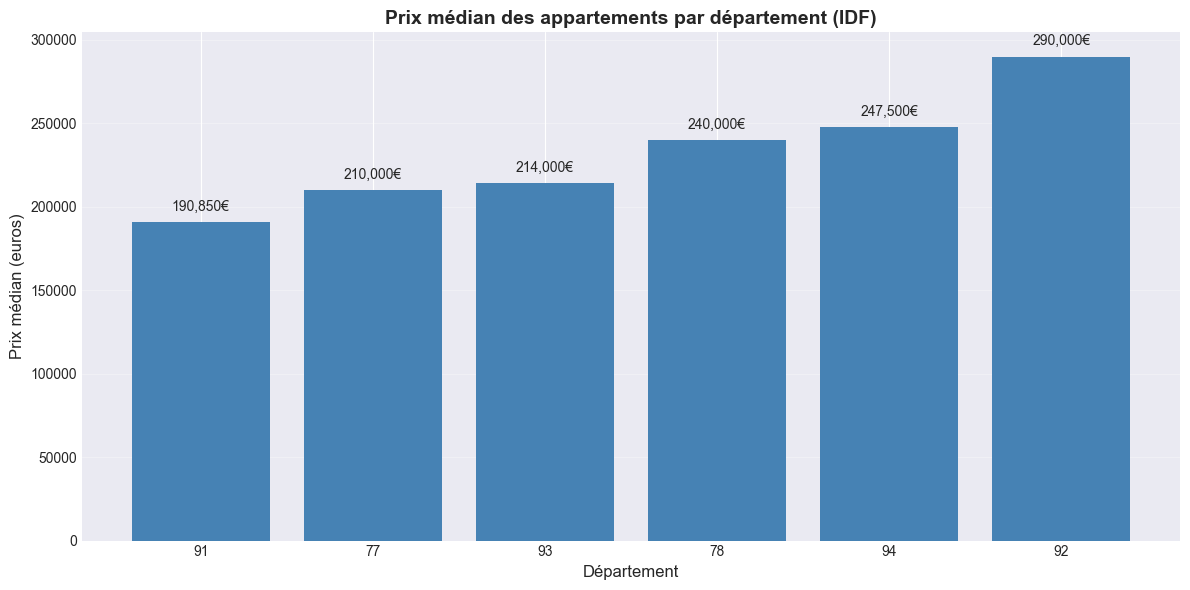


Département le plus cher : 92 (290,000 euros)
Département le moins cher : 91 (190,850 euros)


In [3]:
print("Widget 1 : Distribution des prix par département")

fig, ax = plt.subplots(figsize=(12, 6))

prix_par_dept = df.groupby('code_departement')['valeur_fonciere'].median().sort_values()

ax.bar(prix_par_dept.index, prix_par_dept.values, color='steelblue')
ax.set_xlabel('Département', fontsize=12)
ax.set_ylabel('Prix médian (euros)', fontsize=12)
ax.set_title('Prix médian des appartements par département (IDF)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(prix_par_dept.values):
    ax.text(i, v + 5000, f'{v:,.0f}€', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nDépartement le plus cher : {prix_par_dept.index[-1]} ({prix_par_dept.values[-1]:,.0f} euros)")
print(f"Département le moins cher : {prix_par_dept.index[0]} ({prix_par_dept.values[0]:,.0f} euros)")

Widget 2 : Evolution des prix médians 2022-2024


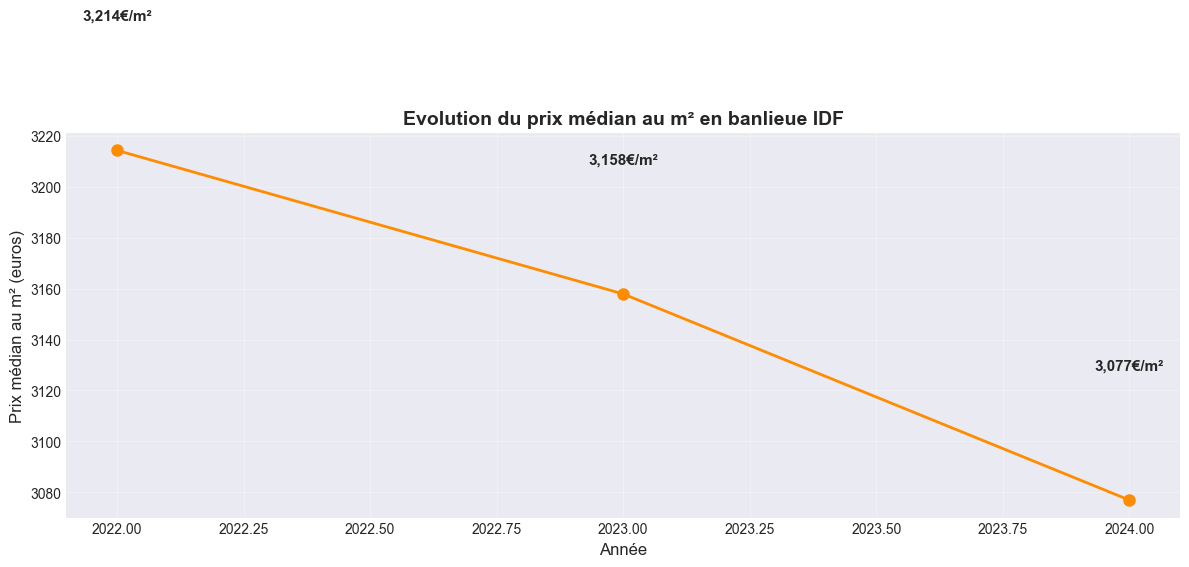


Variation 2022-2024 : -4.3%


In [4]:
print("Widget 2 : Evolution des prix médians 2022-2024")

fig, ax = plt.subplots(figsize=(12, 6))

evolution = df.groupby('annee')['prix_m2'].median().sort_index()

ax.plot(evolution.index, evolution.values, marker='o', linewidth=2, markersize=8, color='darkorange')
ax.set_xlabel('Année', fontsize=12)
ax.set_ylabel('Prix médian au m² (euros)', fontsize=12)
ax.set_title('Evolution du prix médian au m² en banlieue IDF', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

for x, y in zip(evolution.index, evolution.values):
    ax.text(x, y + 50, f'{y:,.0f}€/m²', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

variation = ((evolution.iloc[-1] - evolution.iloc[0]) / evolution.iloc[0]) * 100
print(f"\nVariation 2022-2024 : {variation:+.1f}%")

Widget 3 : Top 10 communes les plus abordables


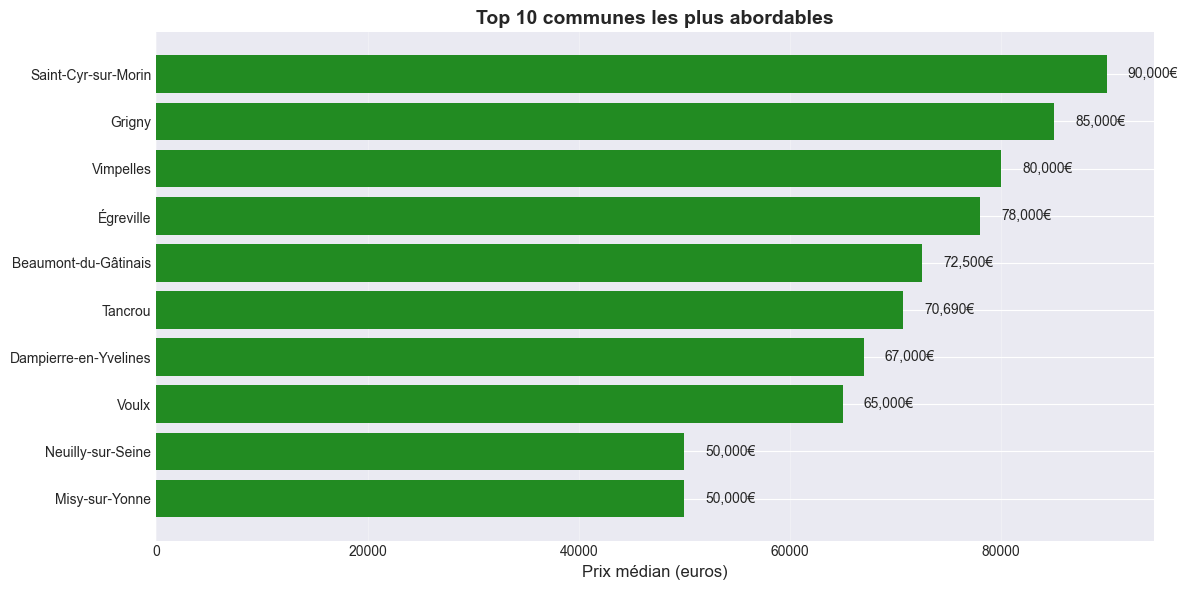

In [5]:
print("Widget 3 : Top 10 communes les plus abordables")

fig, ax = plt.subplots(figsize=(12, 6))

top_communes = df.groupby('nom_commune')['valeur_fonciere'].median().sort_values().head(10)

ax.barh(range(len(top_communes)), top_communes.values, color='forestgreen')
ax.set_yticks(range(len(top_communes)))
ax.set_yticklabels(top_communes.index)
ax.set_xlabel('Prix médian (euros)', fontsize=12)
ax.set_title('Top 10 communes les plus abordables', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(top_communes.values):
    ax.text(v + 2000, i, f'{v:,.0f}€', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [6]:
print("Widget 4 : Filtre interactif par budget")

def update_budget_filter(budget_max):
    biens_dispo = df[df['valeur_fonciere'] <= budget_max]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Graphique 1 : Nombre de biens par département
    nb_par_dept = biens_dispo['code_departement'].value_counts().sort_index()
    ax1.bar(nb_par_dept.index, nb_par_dept.values, color='steelblue')
    ax1.set_title(f'Biens disponibles par département (budget <= {budget_max:,} euros)')
    ax1.set_xlabel('Département')
    ax1.set_ylabel('Nombre de biens')
    ax1.grid(axis='y', alpha=0.3)
    
    # Graphique 2 : Distribution des prix
    ax2.hist(biens_dispo['valeur_fonciere'], bins=30, color='coral', edgecolor='black')
    ax2.set_title('Distribution des prix')
    ax2.set_xlabel('Prix (euros)')
    ax2.set_ylabel('Nombre de biens')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nNombre de biens disponibles : {len(biens_dispo):,}")
    print(f"Prix moyen : {biens_dispo['valeur_fonciere'].mean():,.0f} euros")
    print(f"Prix médian : {biens_dispo['valeur_fonciere'].median():,.0f} euros")

budget_slider = widgets.IntSlider(
    value=230000,
    min=100000,
    max=400000,
    step=10000,
    description='Budget max :',
    style={'description_width': '120px'},
    continuous_update=False
)

widgets.interact(update_budget_filter, budget_max=budget_slider)

Widget 4 : Filtre interactif par budget


interactive(children=(IntSlider(value=230000, continuous_update=False, description='Budget max :', max=400000,…

<function __main__.update_budget_filter(budget_max)>

In [7]:
print("Widget 5 : Analyse détaillée par commune")

def analyse_commune(commune):
    biens_commune = df[df['nom_commune'] == commune]
    
    if len(biens_commune) == 0:
        print(f"Aucun bien disponible à {commune}")
        return
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Graphique 1 : Distribution des prix
    ax1.hist(biens_commune['valeur_fonciere'], bins=20, color='steelblue', edgecolor='black')
    ax1.set_title(f'Distribution des prix à {commune}')
    ax1.set_xlabel('Prix (euros)')
    ax1.set_ylabel('Nombre de biens')
    ax1.axvline(biens_commune['valeur_fonciere'].median(), color='red', linestyle='--', label='Médiane')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
     # Graphique 2 : Evolution en % (base 2022)
    prix_annee = biens_commune.groupby('annee')['valeur_fonciere'].median()
    if len(prix_annee) > 1:
        prix_base = prix_annee.iloc[0]
        evolution_pct = ((prix_annee - prix_base) / prix_base * 100)
        ax2.plot(evolution_pct.index, evolution_pct.values, marker='o', color='darkorange', linewidth=2, markersize=8)
        ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
        ax2.set_title(f'Evolution des prix à {commune} (base 2022)')
        ax2.set_xlabel('Année')
        ax2.set_ylabel('Evolution (%)')
        ax2.grid(True, alpha=0.3)
        for x, y in zip(evolution_pct.index, evolution_pct.values):
            ax2.text(x, y + 1, f'{y:+.1f}%', ha='center', fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'Données insuffisantes', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Evolution des prix')
    
    # Graphique 3 : Répartition 3 vs 4 pièces
    pieces_count = biens_commune['nombre_pieces_principales'].value_counts()
    ax3.pie(pieces_count.values, labels=[f'{int(p)} pièces' for p in pieces_count.index], 
            autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
    ax3.set_title('Répartition 3 vs 4 pièces')
    
    # Graphique 4 : Distance moyenne aux POI
    distances = {
        'Gare': biens_commune['distance_gare_m'].mean(),
        'École': biens_commune['distance_ecole_m'].mean(),
        'Espace vert': biens_commune['distance_espace_vert_m'].mean()
    }
    ax4.barh(list(distances.keys()), list(distances.values()), color='forestgreen')
    ax4.set_title('Distance moyenne aux points d\'intérêt')
    ax4.set_xlabel('Distance (mètres)')
    ax4.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Stats textuelles
    print(f"\n=== Statistiques pour {commune} ===")
    print(f"Nombre de biens : {len(biens_commune):,}")
    print(f"Prix moyen : {biens_commune['valeur_fonciere'].mean():,.0f} euros")
    print(f"Prix médian : {biens_commune['valeur_fonciere'].median():,.0f} euros")
    print(f"Prix/m² moyen : {biens_commune['prix_m2'].mean():,.0f} euros/m²")
    print(f"Surface moyenne : {biens_commune['surface_reelle_bati'].mean():.1f} m²")
    print(f"\nBiens respectant tous les critères : {biens_commune['respecte_tous_criteres'].sum():,} ({biens_commune['respecte_tous_criteres'].mean()*100:.1f}%)")
    
    if biens_commune['evolution_prix_2022_2024_pct'].notna().any():
        evo = biens_commune['evolution_prix_2022_2024_pct'].iloc[0]
        print(f"Evolution 2022-2024 : {evo:+.1f}%")

communes_list = sorted(df['nom_commune'].unique())

commune_dropdown = widgets.Dropdown(
    options=communes_list,
    value=communes_list[0],
    description='Commune :',
    style={'description_width': '100px'}
)

widgets.interact(analyse_commune, commune=commune_dropdown)

Widget 5 : Analyse détaillée par commune


interactive(children=(Dropdown(description='Commune :', options=('Ablis', 'Ablon-sur-Seine', 'Achères', 'Alfor…

<function __main__.analyse_commune(commune)>

In [8]:
print("Widget 6 : Filtres multiples - Budget et Surface")

def filtre_budget_surface(budget_max, surface_min):
    biens_filtres = df[
        (df['valeur_fonciere'] <= budget_max) & 
        (df['surface_reelle_bati'] >= surface_min)
    ]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Graphique 1 : Scatter plot Prix vs Surface
    couleurs = biens_filtres['respecte_tous_criteres'].map({True: 'green', False: 'gray'})
    ax1.scatter(biens_filtres['surface_reelle_bati'], biens_filtres['valeur_fonciere'], 
                c=couleurs, alpha=0.5, s=20)
    ax1.set_xlabel('Surface (m²)')
    ax1.set_ylabel('Prix (euros)')
    ax1.set_title('Prix vs Surface')
    ax1.grid(True, alpha=0.3)
    
    # Légende personnalisée
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', label='Respecte tous les critères'),
        Patch(facecolor='gray', label='Ne respecte pas tous les critères')
    ]
    ax1.legend(handles=legend_elements, loc='upper left')
    
    # Graphique 2 : Top 10 communes
    top_communes = biens_filtres['nom_commune'].value_counts().head(10)
    ax2.barh(range(len(top_communes)), top_communes.values, color='steelblue')
    ax2.set_yticks(range(len(top_communes)))
    ax2.set_yticklabels(top_communes.index)
    ax2.set_xlabel('Nombre de biens')
    ax2.set_title('Top 10 communes')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nBiens correspondants : {len(biens_filtres):,}")
    print(f"Prix moyen : {biens_filtres['valeur_fonciere'].mean():,.0f} euros")
    print(f"Prix/m² moyen : {biens_filtres['prix_m2'].mean():,.0f} euros/m²")
    print(f"Biens parfaits (tous critères) : {biens_filtres['respecte_tous_criteres'].sum():,}")

budget_slider = widgets.IntSlider(
    value=230000, min=100000, max=400000, step=10000,
    description='Budget max :', style={'description_width': '120px'},
    continuous_update=False
)

surface_slider = widgets.IntSlider(
    value=60, min=50, max=120, step=5,
    description='Surface min :', style={'description_width': '120px'},
    continuous_update=False
)

widgets.interact(filtre_budget_surface, budget_max=budget_slider, surface_min=surface_slider)

Widget 6 : Filtres multiples - Budget et Surface


interactive(children=(IntSlider(value=230000, continuous_update=False, description='Budget max :', max=400000,…

<function __main__.filtre_budget_surface(budget_max, surface_min)>

In [9]:
print("Widget 7 : Filtres par distances aux points d'intérêt")

def filtre_distances_poi(distance_gare, distance_ecole, distance_espace_vert):
    biens_filtres = df[
        (df['distance_gare_m'] <= distance_gare) &
        (df['distance_ecole_m'] <= distance_ecole) &
        (df['distance_espace_vert_m'] <= distance_espace_vert)
    ]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # Graphique 1 : Distribution distances aux gares
    ax1.hist(biens_filtres['distance_gare_m'], bins=30, color='steelblue', edgecolor='black')
    ax1.axvline(distance_gare, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Distance (mètres)')
    ax1.set_ylabel('Nombre de biens')
    ax1.set_title('Distance aux gares/stations')
    ax1.grid(axis='y', alpha=0.3)
    
    # Graphique 2 : Distribution distances aux écoles
    ax2.hist(biens_filtres['distance_ecole_m'], bins=30, color='coral', edgecolor='black')
    ax2.axvline(distance_ecole, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Distance (mètres)')
    ax2.set_ylabel('Nombre de biens')
    ax2.set_title('Distance aux écoles')
    ax2.grid(axis='y', alpha=0.3)
    
    # Graphique 3 : Distribution distances aux espaces verts
    ax3.hist(biens_filtres['distance_espace_vert_m'], bins=30, color='forestgreen', edgecolor='black')
    ax3.axvline(distance_espace_vert, color='red', linestyle='--', linewidth=2)
    ax3.set_xlabel('Distance (mètres)')
    ax3.set_ylabel('Nombre de biens')
    ax3.set_title('Distance aux espaces verts')
    ax3.grid(axis='y', alpha=0.3)
    
    # Graphique 4 : Top 10 communes
    top_communes = biens_filtres['nom_commune'].value_counts().head(10)
    ax4.barh(range(len(top_communes)), top_communes.values, color='purple')
    ax4.set_yticks(range(len(top_communes)))
    ax4.set_yticklabels(top_communes.index)
    ax4.set_xlabel('Nombre de biens')
    ax4.set_title('Top 10 communes')
    ax4.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nBiens respectant les critères de distance : {len(biens_filtres):,}")
    print(f"Pourcentage du total : {len(biens_filtres)/len(df)*100:.1f}%")
    print(f"Prix médian : {biens_filtres['valeur_fonciere'].median():,.0f} euros")
    print(f"\nDistances moyennes :")
    print(f"  - Gare : {biens_filtres['distance_gare_m'].mean():.0f}m")
    print(f"  - École : {biens_filtres['distance_ecole_m'].mean():.0f}m")
    print(f"  - Espace vert : {biens_filtres['distance_espace_vert_m'].mean():.0f}m")

slider_gare = widgets.IntSlider(
    value=600, min=200, max=2000, step=100,
    description='Gare max :', style={'description_width': '120px'},
    continuous_update=False
)

slider_ecole = widgets.IntSlider(
    value=250, min=100, max=1000, step=50,
    description='École max :', style={'description_width': '120px'},
    continuous_update=False
)

slider_espace_vert = widgets.IntSlider(
    value=800, min=200, max=2000, step=100,
    description='Esp. vert max :', style={'description_width': '120px'},
    continuous_update=False
)

widgets.interact(filtre_distances_poi, distance_gare=slider_gare, 
                 distance_ecole=slider_ecole, distance_espace_vert=slider_espace_vert)

Widget 7 : Filtres par distances aux points d'intérêt


interactive(children=(IntSlider(value=600, continuous_update=False, description='Gare max :', max=2000, min=20…

<function __main__.filtre_distances_poi(distance_gare, distance_ecole, distance_espace_vert)>

In [10]:
print("Widget 8 : Carte interactive complète")

def creer_carte_interactive(prix_min, prix_max, pieces, seulement_parfaits, afficher_gares, afficher_ecoles, afficher_espaces_verts):
    
    # Filtrage des biens
    biens_filtres = df[
        (df['valeur_fonciere'] >= prix_min) &
        (df['valeur_fonciere'] <= prix_max)
    ]
    
    if pieces != 'Toutes':
        biens_filtres = biens_filtres[biens_filtres['nombre_pieces_principales'] == int(pieces)]
    
    if seulement_parfaits:
        biens_filtres = biens_filtres[biens_filtres['respecte_tous_criteres'] == True]
    
    # Centrer la carte sur l'IDF
    centre_lat = biens_filtres['latitude'].mean()
    centre_lon = biens_filtres['longitude'].mean()
    
    carte = folium.Map(location=[centre_lat, centre_lon], zoom_start=10, tiles='OpenStreetMap')
    
    # Cluster pour les biens
    marker_cluster_biens = plugins.MarkerCluster(name='Biens immobiliers').add_to(carte)
    
    # Ajouter les biens au cluster
    for idx, bien in biens_filtres.iterrows():
        couleur = 'green' if bien['respecte_tous_criteres'] else 'blue'
        
        popup_text = f"""
        <b>{bien['nom_commune']}</b><br>
        Prix : {bien['valeur_fonciere']:,.0f} €<br>
        Surface : {bien['surface_reelle_bati']:.0f} m²<br>
        Prix/m² : {bien['prix_m2']:,.0f} €/m²<br>
        Pièces : {int(bien['nombre_pieces_principales'])}<br>
        <hr>
        Distance gare : {bien['distance_gare_m']:.0f}m ({bien['gare_la_plus_proche']})<br>
        Distance école : {bien['distance_ecole_m']:.0f}m<br>
        Distance esp. vert : {bien['distance_espace_vert_m']:.0f}m
        """
        
        folium.CircleMarker(
            location=[bien['latitude'], bien['longitude']],
            radius=4,
            popup=folium.Popup(popup_text, max_width=250),
            color=couleur,
            fill=True,
            fillOpacity=0.7
        ).add_to(marker_cluster_biens)
    
    # Ajouter les gares
    if afficher_gares:
        gares_uniques = biens_filtres[['gare_la_plus_proche', 'type_transport']].drop_duplicates('gare_la_plus_proche').head(100)
        for idx, row in gares_uniques.iterrows():
            bien_gare = biens_filtres[biens_filtres['gare_la_plus_proche'] == row['gare_la_plus_proche']].iloc[0]
            folium.Marker(
                location=[bien_gare['latitude'], bien_gare['longitude']],
                popup=f"{row['gare_la_plus_proche']} ({row['type_transport']})",
                icon=folium.Icon(color='red', icon='train', prefix='fa')
            ).add_to(carte)
    
    # Ajouter les écoles
    if afficher_ecoles:
        ecoles_uniques = biens_filtres[['ecole_la_plus_proche']].drop_duplicates('ecole_la_plus_proche').head(100)
        for idx, row in ecoles_uniques.iterrows():
            bien_ecole = biens_filtres[biens_filtres['ecole_la_plus_proche'] == row['ecole_la_plus_proche']].iloc[0]
            folium.Marker(
                location=[bien_ecole['latitude'], bien_ecole['longitude']],
                popup=f"École : {row['ecole_la_plus_proche']}",
                icon=folium.Icon(color='blue', icon='graduation-cap', prefix='fa')
            ).add_to(carte)
    
    # Ajouter les espaces verts
    if afficher_espaces_verts:
        ev_uniques = biens_filtres[['espace_vert_le_plus_proche']].drop_duplicates('espace_vert_le_plus_proche').head(100)
        for idx, row in ev_uniques.iterrows():
            bien_ev = biens_filtres[biens_filtres['espace_vert_le_plus_proche'] == row['espace_vert_le_plus_proche']].iloc[0]
            folium.Marker(
                location=[bien_ev['latitude'], bien_ev['longitude']],
                popup=f"Espace vert : {row['espace_vert_le_plus_proche']}",
                icon=folium.Icon(color='green', icon='tree', prefix='fa')
            ).add_to(carte)
    
    # Légende
    legend_html = f'''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 240px; 
    background-color: white; border:2px solid grey; z-index:9999; font-size:13px; padding: 10px">
    <p><b>Carte interactive</b></p>
    <p><i class="fa fa-circle" style="color:green"></i> Biens parfaits ({biens_filtres['respecte_tous_criteres'].sum():,})</p>
    <p><i class="fa fa-circle" style="color:blue"></i> Autres biens</p>
    <p><i class="fa fa-map-marker" style="color:red"></i> Gares/Stations</p>
    <p><i class="fa fa-map-marker" style="color:blue"></i> Écoles</p>
    <p><i class="fa fa-map-marker" style="color:green"></i> Espaces verts</p>
    </div>
    '''
    carte.get_root().html.add_child(folium.Element(legend_html))
    
    print(f"\nBiens affichés : {len(biens_filtres):,}")
    print(f"Prix moyen : {biens_filtres['valeur_fonciere'].mean():,.0f} euros")
    
    return carte

# Widgets
prix_min_slider = widgets.IntSlider(value=100000, min=50000, max=300000, step=10000, description='Prix min :', style={'description_width': '100px'})
prix_max_slider = widgets.IntSlider(value=300000, min=100000, max=500000, step=10000, description='Prix max :', style={'description_width': '100px'})
pieces_dropdown = widgets.Dropdown(options=['Toutes', '3', '4'], value='Toutes', description='Pièces :', style={'description_width': '100px'})
parfaits_check = widgets.Checkbox(value=False, description='Seulement biens parfaits')
gares_check = widgets.Checkbox(value=True, description='Afficher gares')
ecoles_check = widgets.Checkbox(value=True, description='Afficher écoles')
ev_check = widgets.Checkbox(value=True, description='Afficher espaces verts')

widgets.interact(creer_carte_interactive, 
                 prix_min=prix_min_slider,
                 prix_max=prix_max_slider,
                 pieces=pieces_dropdown,
                 seulement_parfaits=parfaits_check,
                 afficher_gares=gares_check,
                 afficher_ecoles=ecoles_check,
                 afficher_espaces_verts=ev_check)

Widget 8 : Carte interactive complète


interactive(children=(IntSlider(value=100000, description='Prix min :', max=300000, min=50000, step=10000, sty…

<function __main__.creer_carte_interactive(prix_min, prix_max, pieces, seulement_parfaits, afficher_gares, afficher_ecoles, afficher_espaces_verts)>

In [11]:
print("Widget 9 : Dashboard de recommandations personnalisées")

def dashboard_recommandations(budget_max, surface_min, distance_gare_max, distance_ecole_max, pieces):
    
    # Filtrer selon tous les critères
    biens_recommandes = df[
        (df['valeur_fonciere'] <= budget_max) &
        (df['surface_reelle_bati'] >= surface_min) &
        (df['distance_gare_m'] <= distance_gare_max) &
        (df['distance_ecole_m'] <= distance_ecole_max)
    ]
    
    if pieces != 'Toutes':
        biens_recommandes = biens_recommandes[biens_recommandes['nombre_pieces_principales'] == int(pieces)]
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Graphique 1 : Top 10 communes recommandées
    ax1 = fig.add_subplot(gs[0, :2])
    top_communes = biens_recommandes['nom_commune'].value_counts().head(10)
    ax1.barh(range(len(top_communes)), top_communes.values, color='steelblue')
    ax1.set_yticks(range(len(top_communes)))
    ax1.set_yticklabels(top_communes.index)
    ax1.set_xlabel('Nombre de biens disponibles')
    ax1.set_title('Top 10 communes recommandées', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Graphique 2 : Stats clés
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.axis('off')
    stats_text = f"""
    STATISTIQUES
    
    Biens trouvés : {len(biens_recommandes):,}
    
    Prix moyen : {biens_recommandes['valeur_fonciere'].mean():,.0f} €
    
    Prix médian : {biens_recommandes['valeur_fonciere'].median():,.0f} €
    
    Prix/m² moyen : {biens_recommandes['prix_m2'].mean():,.0f} €/m²
    
    Biens parfaits : {biens_recommandes['respecte_tous_criteres'].sum():,}
    """
    ax2.text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center', family='monospace')
    
    # Graphique 3 : Distribution des prix
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.hist(biens_recommandes['valeur_fonciere'], bins=30, color='coral', edgecolor='black')
    ax3.set_xlabel('Prix (euros)')
    ax3.set_ylabel('Nombre de biens')
    ax3.set_title('Distribution des prix')
    ax3.grid(axis='y', alpha=0.3)
    
    # Graphique 4 : Distribution prix/m²
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.hist(biens_recommandes['prix_m2'], bins=30, color='lightgreen', edgecolor='black')
    ax4.set_xlabel('Prix/m² (euros)')
    ax4.set_ylabel('Nombre de biens')
    ax4.set_title('Distribution prix au m²')
    ax4.grid(axis='y', alpha=0.3)
    
    # Graphique 5 : Scatter Prix vs Surface
    ax5 = fig.add_subplot(gs[1, 2])
    couleurs = biens_recommandes['respecte_tous_criteres'].map({True: 'green', False: 'gray'})
    ax5.scatter(biens_recommandes['surface_reelle_bati'], biens_recommandes['valeur_fonciere'], 
                c=couleurs, alpha=0.5, s=10)
    ax5.set_xlabel('Surface (m²)')
    ax5.set_ylabel('Prix (euros)')
    ax5.set_title('Prix vs Surface')
    ax5.grid(True, alpha=0.3)
    
    # Graphique 6 : Communes les moins chères
    ax6 = fig.add_subplot(gs[2, :])
    communes_prix = biens_recommandes.groupby('nom_commune')['valeur_fonciere'].median().sort_values().head(15)
    ax6.bar(range(len(communes_prix)), communes_prix.values, color='purple')
    ax6.set_xticks(range(len(communes_prix)))
    ax6.set_xticklabels(communes_prix.index, rotation=45, ha='right')
    ax6.set_ylabel('Prix médian (euros)')
    ax6.set_title('Top 15 communes les plus abordables', fontweight='bold')
    ax6.grid(axis='y', alpha=0.3)
    
    plt.suptitle('DASHBOARD DE RECOMMANDATIONS', fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
    # Recommandations textuelles
    print("\n" + "="*60)
    print("RECOMMANDATIONS PERSONNALISÉES")
    print("="*60)
    
    if len(biens_recommandes) > 0:
        meilleure_commune = biens_recommandes['nom_commune'].value_counts().index[0]
        print(f"\nMeilleure commune : {meilleure_commune}")
        print(f"  - {biens_recommandes[biens_recommandes['nom_commune'] == meilleure_commune].shape[0]} biens disponibles")
        print(f"  - Prix médian : {biens_recommandes[biens_recommandes['nom_commune'] == meilleure_commune]['valeur_fonciere'].median():,.0f} euros")
    else:
        print("\nAucun bien ne correspond à vos critères.")
        print("Essayez d'assouplir certains critères.")

# Widgets
budget_slider = widgets.IntSlider(value=230000, min=100000, max=400000, step=10000, description='Budget max :', style={'description_width': '120px'})
surface_slider = widgets.IntSlider(value=60, min=50, max=120, step=5, description='Surface min :', style={'description_width': '120px'})
distance_gare_slider = widgets.IntSlider(value=600, min=200, max=2000, step=100, description='Gare max :', style={'description_width': '120px'})
distance_ecole_slider = widgets.IntSlider(value=250, min=100, max=1000, step=50, description='École max :', style={'description_width': '120px'})
pieces_dropdown = widgets.Dropdown(options=['Toutes', '3', '4'], value='Toutes', description='Pièces :', style={'description_width': '120px'})

widgets.interact(dashboard_recommandations,
                 budget_max=budget_slider,
                 surface_min=surface_slider,
                 distance_gare_max=distance_gare_slider,
                 distance_ecole_max=distance_ecole_slider,
                 pieces=pieces_dropdown)

Widget 9 : Dashboard de recommandations personnalisées


interactive(children=(IntSlider(value=230000, description='Budget max :', max=400000, min=100000, step=10000, …

<function __main__.dashboard_recommandations(budget_max, surface_min, distance_gare_max, distance_ecole_max, pieces)>